In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

try:
    import pretty_midi
    print(f"pretty_midi version {pretty_midi.__version__} found.")
except ImportError:
    print("pretty_midi not found. Installing...")
    !pip install pretty_midi -q
    import pretty_midi
    print(f"pretty_midi version {pretty_midi.__version__} installed.")

try:
    import librosa
    import librosa.display
except ImportError:
     print("librosa not found. Installing...")
     !pip install librosa -q
     import librosa
     import librosa.display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

midi_save_dir = "/kaggle/working/generated_midi/"
os.makedirs(midi_save_dir, exist_ok=True)
viz_save_dir = "/kaggle/working/generated_viz/"
os.makedirs(viz_save_dir, exist_ok=True)

pretty_midi not found. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
pretty_midi version 0.2.10 installed.
Using device: cuda


In [2]:
import pretty_midi
import os
import glob
import numpy as np
import random
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader

midi_base_path = "/kaggle/input/lakh-midi-clean/Aerosmith"

max_files_to_process = 100

sequence_length = 100

all_midi_files = []
print(f"Searching for MIDI files in: {midi_base_path}")
try:
    all_midi_files = glob.glob(os.path.join(midi_base_path, '**', '*.mid'), recursive=True)
    if not all_midi_files:
         all_midi_files = glob.glob(os.path.join(midi_base_path, '**', '*.midi'), recursive=True)

    if not all_midi_files:
         print(f"ERROR: No MIDI files found in {midi_base_path}. Check the path.")
    else:
        print(f"Found {len(all_midi_files)} total MIDI files.")
        if len(all_midi_files) > max_files_to_process:
            print(f"Randomly selecting {max_files_to_process} files to process...")
            midi_files_to_process = random.sample(all_midi_files, max_files_to_process)
        else:
            print(f"Processing all {len(all_midi_files)} found files.")
            midi_files_to_process = all_midi_files

except FileNotFoundError:
    print(f"ERROR: Directory not found: {midi_base_path}")
    midi_files_to_process = []
except Exception as e:
    print(f"An error occurred finding MIDI files: {e}")
    midi_files_to_process = []

all_notes = []
print(f"\nParsing selected {len(midi_files_to_process)} MIDI files...")

for i, file_path in enumerate(tqdm(midi_files_to_process, desc="Parsing MIDI")):
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)

        instrument_notes = []
        best_instrument_notes = []
        max_notes = -1

        for instrument in midi_data.instruments:
            if len(instrument.notes) > max_notes:
                 max_notes = len(instrument.notes)
                 sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
                 best_instrument_notes = [note.pitch for note in sorted_notes] 

        if best_instrument_notes:
             all_notes.extend(best_instrument_notes)

    except Exception as e:
        pass

print(f"\nTotal notes extracted: {len(all_notes)}")

if not all_notes:
    print("ERROR: No notes were extracted. Cannot proceed. Check MIDI files or parsing logic.")
else:

    note_counts = Counter(all_notes)
    unique_notes = sorted(note_counts.keys())
    n_vocab = len(unique_notes)
    print(f"Vocabulary size (unique notes): {n_vocab}")

    note_to_int = {note: number for number, note in enumerate(unique_notes)}
    int_to_note = {number: note for number, note in enumerate(unique_notes)}

    network_input = []
    network_output = []

    numerical_notes = [note_to_int[note] for note in all_notes]

    print(f"Preparing sequences of length {sequence_length}...")
    for i in range(0, len(numerical_notes) - sequence_length, 1):
        sequence_in = numerical_notes[i : i + sequence_length]
        sequence_out = numerical_notes[i + sequence_length]
        network_input.append(sequence_in)
        network_output.append(sequence_out)

    n_patterns = len(network_input)
    print(f"Total training patterns (sequences): {n_patterns}")

    if n_patterns == 0:
         print("ERROR: Could not create any training patterns. Sequence length might be too large for the data.")
    else:
        network_input_np = np.reshape(network_input, (n_patterns, sequence_length))
        network_input_final = network_input_np

        network_output_np = np.array(network_output)

        input_tensor = torch.tensor(network_input_final, dtype=torch.long) 
        output_tensor = torch.tensor(network_output_np, dtype=torch.long) 

        class MIDIDataset(Dataset):
            def __init__(self, inputs, outputs):
                self.inputs = inputs
                self.outputs = outputs

            def __len__(self):
                return len(self.inputs)

            def __getitem__(self, idx):
                return self.inputs[idx], self.outputs[idx]

        train_dataset = MIDIDataset(input_tensor, output_tensor)
        batch_size_midi = 128
        train_loader_midi = DataLoader(train_dataset, batch_size=batch_size_midi, shuffle=True, drop_last=True)

        print("\nData preprocessing finished.")
        print(f"Input tensor shape: {input_tensor.shape}")  
        print(f"Output tensor shape: {output_tensor.shape}")
        print(f"Number of training batches: {len(train_loader_midi)}")

Searching for MIDI files in: /kaggle/input/lakh-midi-clean/Aerosmith
Found 43 total MIDI files.
Processing all 43 found files.

Parsing selected 43 MIDI files...


Parsing MIDI:   2%|▏         | 1/43 [00:00<00:04,  9.13it/s]/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Parsing MIDI: 100%|██████████| 43/43 [00:05<00:00,  8.35it/s]



Total notes extracted: 58268
Vocabulary size (unique notes): 55
Preparing sequences of length 100...
Total training patterns (sequences): 58168

Data preprocessing finished.
Input tensor shape: torch.Size([58168, 100])
Output tensor shape: torch.Size([58168])
Number of training batches: 454


In [3]:
import torch
import torch.nn as nn

embedding_dim = 256  
hidden_size = 512    
num_layers = 2       
dropout_prob = 0.3 
try:
    if 'n_vocab' not in locals():
         raise NameError("n_vocab is not defined.")
    print(f"Vocabulary size (n_vocab) for model: {n_vocab}")
except NameError as e:
    print(f"ERROR: {e}")
    n_vocab = 100
    print(f"Using placeholder n_vocab: {n_vocab}. RUN STEP C.2!")


class MusicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout=0.3):
        super(MusicLSTM, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0) 

        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):

        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)

        last_lstm_out = lstm_out[:, -1, :]

        out = self.dropout(last_lstm_out)

        out = self.fc_out(out)
        return out

music_lstm_model = MusicLSTM(n_vocab, embedding_dim, hidden_size, num_layers, dropout_prob).to(device)

print("\n--- Music LSTM Model Architecture ---")
print(music_lstm_model)

total_params = sum(p.numel() for p in music_lstm_model.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters: {total_params:,}")

Vocabulary size (n_vocab) for model: 55

--- Music LSTM Model Architecture ---
MusicLSTM(
  (embedding): Embedding(55, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=512, out_features=55, bias=True)
)

Total Trainable Parameters: 3,720,503


Model, DataLoader, device, and n_vocab seem to be defined.

--- Starting Model Training ---


Epoch 1/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [1/50], Loss: 1.2373, Time: 27.51s


Epoch 2/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.7170, Time: 26.75s


Epoch 3/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.5819, Time: 26.84s


Epoch 4/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.5022, Time: 27.17s


Epoch 5/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.4489, Time: 27.20s


Epoch 6/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.4203, Time: 27.08s


Epoch 7/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.3921, Time: 27.05s


Epoch 8/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.3737, Time: 27.06s


Epoch 9/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.3533, Time: 27.22s


Epoch 10/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.3391, Time: 27.09s


Epoch 11/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.3304, Time: 27.15s


Epoch 12/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.3166, Time: 27.10s


Epoch 13/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.3095, Time: 27.14s


Epoch 14/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.3000, Time: 27.12s


Epoch 15/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.2918, Time: 27.13s


Epoch 16/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.2888, Time: 27.15s


Epoch 17/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.2833, Time: 27.12s


Epoch 18/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.2771, Time: 27.13s


Epoch 19/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.2743, Time: 27.17s


Epoch 20/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.2678, Time: 27.19s


Epoch 21/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.2676, Time: 27.11s


Epoch 22/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.2636, Time: 27.13s


Epoch 23/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.2629, Time: 27.21s


Epoch 24/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [24/50], Loss: 0.2625, Time: 27.11s


Epoch 25/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [25/50], Loss: 0.2556, Time: 27.16s


Epoch 26/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [26/50], Loss: 0.2568, Time: 27.16s


Epoch 27/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [27/50], Loss: 0.2542, Time: 27.18s


Epoch 28/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [28/50], Loss: 0.2539, Time: 27.14s


Epoch 29/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [29/50], Loss: 0.2477, Time: 27.13s


Epoch 30/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [30/50], Loss: 0.2491, Time: 27.15s


Epoch 31/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [31/50], Loss: 0.2469, Time: 27.16s


Epoch 32/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [32/50], Loss: 0.2434, Time: 27.14s


Epoch 33/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [33/50], Loss: 0.2462, Time: 27.14s


Epoch 34/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [34/50], Loss: 0.2490, Time: 27.17s


Epoch 35/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [35/50], Loss: 0.2505, Time: 27.14s


Epoch 36/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [36/50], Loss: 0.2476, Time: 27.11s


Epoch 37/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [37/50], Loss: 0.2476, Time: 27.19s


Epoch 38/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [38/50], Loss: 0.2459, Time: 27.12s


Epoch 39/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [39/50], Loss: 0.2448, Time: 27.14s


Epoch 40/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [40/50], Loss: 0.2412, Time: 27.13s


Epoch 41/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [41/50], Loss: 0.2464, Time: 27.15s


Epoch 42/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [42/50], Loss: 0.2461, Time: 27.05s


Epoch 43/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [43/50], Loss: 0.2454, Time: 27.06s


Epoch 44/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [44/50], Loss: 0.2460, Time: 27.07s


Epoch 45/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [45/50], Loss: 0.2466, Time: 27.01s


Epoch 46/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [46/50], Loss: 0.2506, Time: 27.00s


Epoch 47/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [47/50], Loss: 0.2484, Time: 27.01s


Epoch 48/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [48/50], Loss: 0.2515, Time: 27.03s


Epoch 49/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [49/50], Loss: 0.2497, Time: 27.00s


Epoch 50/50:   0%|          | 0/454 [00:00<?, ?it/s]

Epoch [50/50], Loss: 0.2523, Time: 27.07s
--- Finished Training in 1355.76 seconds ---


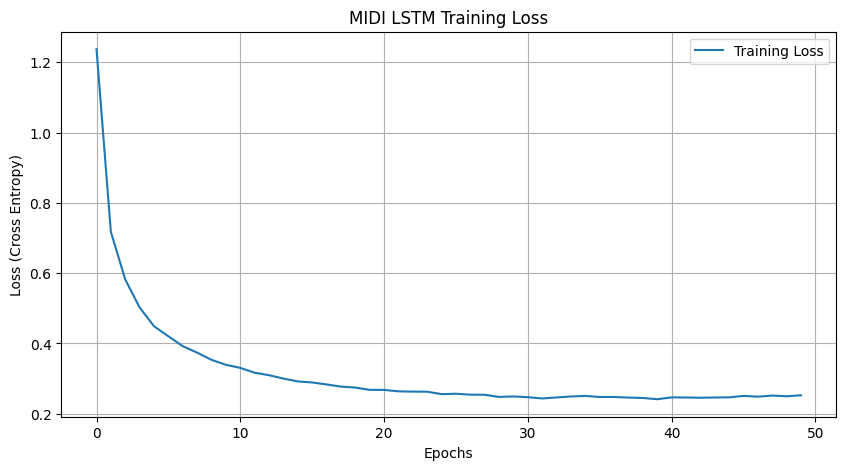

Model state dictionary saved to: /kaggle/working/music_lstm_model.pth


In [4]:
import torch.optim as optim
import torch.nn as nn
import torch 
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import time

num_epochs_midi = 50    
learning_rate = 0.002   
clip_value = 1.0 
try:
    if 'music_lstm_model' not in locals(): raise NameError("music_lstm_model")
    if 'train_loader_midi' not in locals(): raise NameError("train_loader_midi")
    if 'device' not in locals(): raise NameError("device")
    if 'n_vocab' not in locals(): raise NameError("n_vocab")
    print("Model, DataLoader, device, and n_vocab seem to be defined.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run previous steps.")
    raise

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(music_lstm_model.parameters(), lr=learning_rate)

print("\n--- Starting Model Training ---")
start_time_train = time.time()
train_losses_midi = []

music_lstm_model.train() 

for epoch in range(num_epochs_midi):
    epoch_start_time = time.time()
    running_loss = 0.0

    progress_bar_train = tqdm(train_loader_midi, desc=f"Epoch {epoch+1}/{num_epochs_midi}", leave=False)

    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = music_lstm_model(inputs) 
        loss = criterion(outputs, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(music_lstm_model.parameters(), clip_value)

        optimizer.step()

        running_loss += loss.item()

        progress_bar_train.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader_midi)
    train_losses_midi.append(epoch_loss)
    epoch_end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs_midi}], Loss: {epoch_loss:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

end_time_train = time.time()
print(f"--- Finished Training in {end_time_train - start_time_train:.2f} seconds ---")

plt.figure(figsize=(10, 5))
plt.plot(train_losses_midi, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.title('MIDI LSTM Training Loss')
plt.legend()
plt.grid(True)
plt.show()

model_save_path = "/kaggle/working/music_lstm_model.pth"
torch.save(music_lstm_model.state_dict(), model_save_path)
print(f"Model state dictionary saved to: {model_save_path}")

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import random

notes_to_generate = 300   
temperature = 1.0      
try:
    if 'n_vocab' not in locals(): raise NameError("n_vocab")
    if 'sequence_length' not in locals(): raise NameError("sequence_length")
    if 'note_to_int' not in locals(): raise NameError("note_to_int")
    if 'int_to_note' not in locals(): raise NameError("int_to_note")
    if 'network_input' not in locals(): raise NameError("network_input (from Step C.2 for seed)")
    if 'device' not in locals(): raise NameError("device")
    if 'MusicLSTM' not in locals(): raise NameError("MusicLSTM class definition")
    print("Required variables for generation seem to be defined.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. ")
    raise
model_load_path = "/kaggle/working/music_lstm_model.pth"
model_loaded_for_gen = False
try:
    embedding_dim = 256
    hidden_size = 512
    num_layers = 2
    dropout_prob = 0.3

    generation_model = MusicLSTM(n_vocab, embedding_dim, hidden_size, num_layers, dropout_prob)
    generation_model.load_state_dict(torch.load(model_load_path))
    generation_model = generation_model.to(device)
    generation_model.eval() 
    print(f"Model loaded successfully from {model_load_path}")
    model_loaded_for_gen = True
except FileNotFoundError:
    print(f"ERROR: Model file not found at {model_load_path}. Did training complete and save the model?")
except Exception as e:
    print(f"ERROR: Failed to load the model: {e}")

generated_sequence_int = []

if model_loaded_for_gen and network_input: 
    print(f"\nGenerating {notes_to_generate} notes...")

    start_index = np.random.randint(0, len(network_input) - 1)
    seed_pattern_int = network_input[start_index] 
    print(f"Using seed pattern index: {start_index}")

    current_sequence_tensor = torch.tensor([seed_pattern_int], dtype=torch.long).to(device)

    generated_sequence_int.extend(seed_pattern_int)

    with torch.no_grad(): 
        for i in tqdm(range(notes_to_generate), desc="Generating Notes"):
            prediction_logits = generation_model(current_sequence_tensor)
            prediction_logits = prediction_logits / temperature

            probabilities = F.softmax(prediction_logits, dim=-1) 

            predicted_index = torch.multinomial(probabilities.squeeze(), num_samples=1).item()

            generated_sequence_int.append(predicted_index)
            current_sequence_np = current_sequence_tensor.cpu().numpy().flatten()
            next_sequence_np = np.append(current_sequence_np[1:], predicted_index)
            current_sequence_tensor = torch.tensor([next_sequence_np], dtype=torch.long).to(device)

    print(f"\nGenerated sequence length: {len(generated_sequence_int)} notes (including seed).")

    generated_notes_midi = [int_to_note[index] for index in generated_sequence_int]
else:
    print("\nCould not generate music because the model wasn't loaded or seed data is missing.")
    generated_notes_midi = [] 


Required variables for generation seem to be defined.
Model loaded successfully from /kaggle/working/music_lstm_model.pth

Generating 300 notes...
Using seed pattern index: 50277


/tmp/ipykernel_19/1582222850.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generation_model.load_state_dict(torch.load(model_load_path))


Generating Notes:   0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_19/1582222850.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  current_sequence_tensor = torch.tensor([next_sequence_np], dtype=torch.long).to(device)



Generated sequence length: 400 notes (including seed).


Generated sequence contains 400 notes.

Creating MIDI notes with fixed duration=0.4s and time_step=0.4s...

Generated MIDI file saved successfully to: /kaggle/working/generated_midi/lstm_generated_melody.mid
You can download this file from the '/kaggle/working/generated_midi/' directory
and listen to it using a MIDI player on your computer or online.

Generating piano roll visualization...


/tmp/ipykernel_19/1266974595.py:59: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll, sr=fs*10,


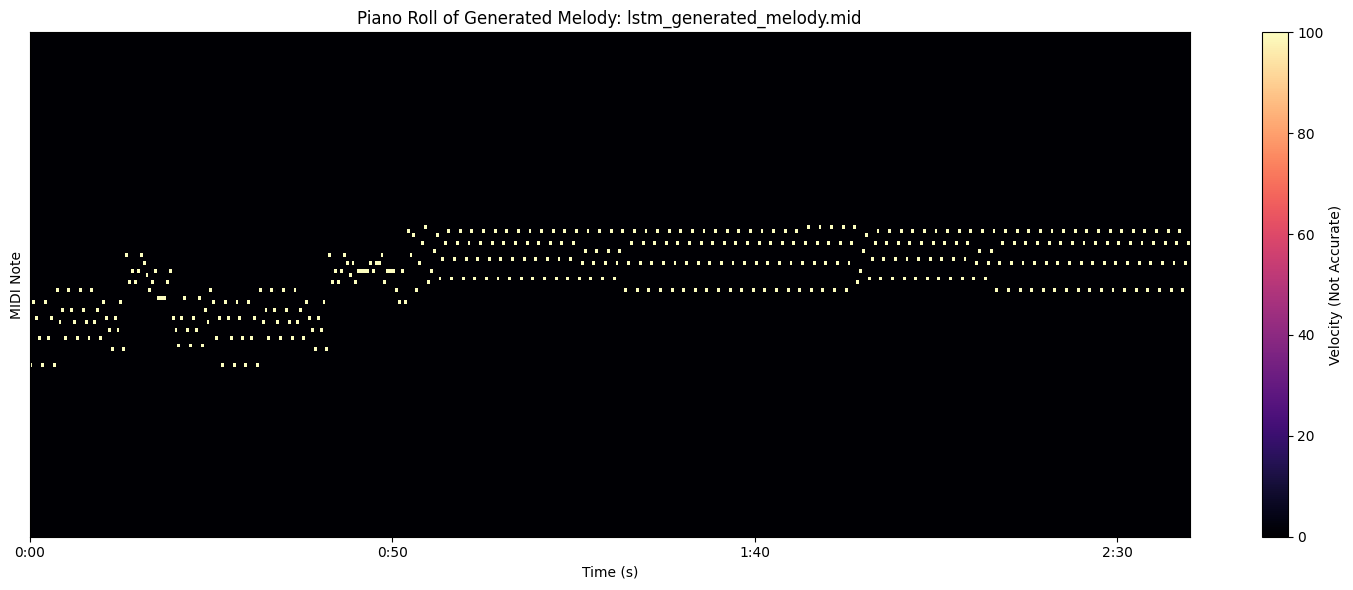

In [6]:
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
try:
    if 'generated_notes_midi' not in locals() or not generated_notes_midi:
         raise NameError("generated_notes_midi list not found or is empty. Please run Step C.5 first.")
    if 'midi_save_dir' not in locals(): raise NameError("midi_save_dir")
    print(f"Generated sequence contains {len(generated_notes_midi)} notes.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run previous steps.")
    raise

midi_filename = "lstm_generated_melody.mid"
midi_filepath = os.path.join(midi_save_dir, midi_filename)

note_duration = 0.4  
time_step = 0.4      
velocity = 100       

try:
    midi_out = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program, name='LSTM Generated Piano')

    current_time = 0.0 
    print(f"\nCreating MIDI notes with fixed duration={note_duration}s and time_step={time_step}s...")

    for pitch in generated_notes_midi:
        start_time = current_time
        end_time = current_time + note_duration
        
        note = pretty_midi.Note(
            velocity=velocity, pitch=int(pitch), start=start_time, end=end_time
        )
        piano.notes.append(note)
        current_time += time_step

    midi_out.instruments.append(piano)

    midi_out.write(midi_filepath)
    print(f"\nGenerated MIDI file saved successfully to: {midi_filepath}")
    print("You can download this file from the '/kaggle/working/generated_midi/' directory")
    print("and listen to it using a MIDI player on your computer or online.")

except Exception as e:
    print(f"\nError creating or saving MIDI file: {e}")

print("\nGenerating piano roll visualization...")
try:
    pm = pretty_midi.PrettyMIDI(midi_filepath)

    fs = 100
    piano_roll = pm.get_piano_roll(fs=fs) # Shape: (128, time_steps)
    plt.figure(figsize=(15, 6))
    times = np.arange(piano_roll.shape[1]) / float(fs)
    librosa.display.specshow(piano_roll, sr=fs*10,
                             hop_length=int(fs*0.1), 
                             x_axis='time', y_axis='cqt_note', 
                             fmin=pretty_midi.note_number_to_hz(1), 
                             cmap='magma') 
    plt.colorbar(label='Velocity (Not Accurate)') 
    plt.title(f'Piano Roll of Generated Melody: {midi_filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Note')
    plt.tight_layout()

    viz_filename = midi_filename.replace('.mid', '.png')
    viz_filepath = os.path.join(viz_save_dir, viz_filename)

    plt.show()

except FileNotFoundError:
    print("Could not visualize: MIDI file not found (was it saved correctly?).")
except Exception as e:
    print(f"Error during visualization: {e}")

In [7]:
import shutil 
import os
from tqdm.notebook import tqdm 

source_midi_dir = "/kaggle/input/lakh-midi-clean/Aerosmith/"

destination_dir = "/kaggle/working/original_aerosmith_midi/"
os.makedirs(destination_dir, exist_ok=True) 

try:
    if 'midi_files_to_process' not in locals() or not midi_files_to_process:
         raise NameError("midi_files_to_process list not found or is empty. Please run Step C.2 again.")

    print(f"Copying {len(midi_files_to_process)} original MIDI files used for training...")
    print(f"Source: {source_midi_dir}")
    print(f"Destination: {destination_dir}")

    copied_count = 0
    error_count = 0
    for source_path in tqdm(midi_files_to_process, desc="Copying MIDI files"):
        try:
            filename = os.path.basename(source_path)
            dest_path = os.path.join(destination_dir, filename)
            shutil.copy2(source_path, dest_path)
            copied_count += 1
        except FileNotFoundError:
             print(f"\nWarning: Source file not found during copy: {source_path}")
             error_count += 1
        except Exception as e:
             print(f"\nError copying {os.path.basename(source_path)}: {e}")
             error_count += 1

    print(f"\nFinished copying. {copied_count} files copied successfully.")
    if error_count > 0:
        print(f"{error_count} files could not be copied.")
    print(f"You can now download the original training MIDI files from the directory: {destination_dir}")
    print("Look for it in the 'Data' -> 'Output' section of your Kaggle notebook.")

except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run Step C.2 first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Copying 43 original MIDI files used for training...
Source: /kaggle/input/lakh-midi-clean/Aerosmith/
Destination: /kaggle/working/original_aerosmith_midi/


Copying MIDI files:   0%|          | 0/43 [00:00<?, ?it/s]


Finished copying. 43 files copied successfully.
You can now download the original training MIDI files from the directory: /kaggle/working/original_aerosmith_midi/
Look for it in the 'Data' -> 'Output' section of your Kaggle notebook.


In [8]:
import pretty_midi
import os
import glob
import numpy as np
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pandas as pd

midi_base_path = "/kaggle/input/lakh-midi-clean/Aerosmith/"
sequence_length_event = 150 
n_time_bins = 32
min_time_shift = 0.01

midi_files_to_process = []
print(f"Searching for MIDI files directly in: {midi_base_path}")
try:
    midi_files_to_process = glob.glob(os.path.join(midi_base_path, '*.mid')) + \
                            glob.glob(os.path.join(midi_base_path, '*.midi'))
    if not midi_files_to_process:
         print(f"ERROR: No MIDI files found in {midi_base_path}. Check the path.")
    else:
        print(f"Found {len(midi_files_to_process)} MIDI files. Processing all.")
except Exception as e:
    print(f"An error occurred finding MIDI files: {e}")
    midi_files_to_process = []

all_events_raw = []
all_time_shifts = []
print(f"\nParsing {len(midi_files_to_process)} MIDI files for events...")

if midi_files_to_process:
    for i, file_path in enumerate(tqdm(midi_files_to_process, desc="Parsing MIDI for Events")):
        try:
            midi_data = pretty_midi.PrettyMIDI(file_path)
            merged_notes = []
            for instrument in midi_data.instruments:
                merged_notes.extend(instrument.notes)
            merged_notes.sort(key=lambda note: note.start)

            last_note_start = 0.0
            file_events = []
            for note in merged_notes:
                time_shift = note.start - last_note_start
                if time_shift >= min_time_shift:
                    all_time_shifts.append(time_shift)
                    file_events.append(f"TIME_SHIFT_{time_shift:.4f}")
                file_events.append(f"NOTE_{note.pitch}")
                last_note_start = note.start
            all_events_raw.extend(file_events)
        except Exception as e:
            pass

print(f"\nTotal raw events extracted: {len(all_events_raw)}")
print(f"Total time shifts collected: {len(all_time_shifts)}")

if not all_events_raw or not all_time_shifts:
    print("ERROR: No events or time shifts extracted. Cannot proceed.")
    all_events_quantized = []
else:
    print(f"Quantizing time shifts into (up to) {n_time_bins} bins using quantiles...")
    time_shift_to_bin_idx = {}
    time_bin_edges = []
    actual_n_time_bins = 0
    try:
        with np.errstate(invalid='ignore'):
            time_shift_series = pd.Series(all_time_shifts)
            try:
                 bin_labels, time_bin_edges = pd.qcut(time_shift_series, q=n_time_bins, labels=False, retbins=True, duplicates='drop')
            except ValueError:
                 print("Quantile cutting failed, switching to linspace.")
                 min_ts, max_ts = np.min(all_time_shifts), np.max(all_time_shifts)
                 if max_ts / min_ts > 1000:
                      time_bin_edges = np.logspace(np.log10(min_ts), np.log10(max_ts), num=n_time_bins + 1)
                 else:
                      time_bin_edges = np.linspace(min_ts, max_ts, num=n_time_bins + 1)
                 time_bin_edges[0] = max(0, time_bin_edges[0] - 1e-6)
                 time_bin_edges[-1] += 1e-6
                 bin_labels = pd.cut(time_shift_series, bins=time_bin_edges, labels=False, right=False, include_lowest=True)

        valid_indices = ~np.isnan(bin_labels)
        unique_valid_bins = np.unique(bin_labels[valid_indices].astype(int)) 
        actual_n_time_bins = len(unique_valid_bins) 
        print(f"Actual number of time bins created: {actual_n_time_bins}")
        print("Time bin edges (seconds):")
        print(np.round(time_bin_edges, 4))

        time_shift_to_bin_idx = {shift: int(bin_idx) for shift, bin_idx in zip(np.array(all_time_shifts)[valid_indices], bin_labels[valid_indices]) if pd.notna(bin_idx)}

        all_events_quantized = []
        for event in all_events_raw:
            if event.startswith("TIME_SHIFT_"):
                time_val = float(event.split("_")[-1])
                bin_idx = -1
                for i in range(len(time_bin_edges) - 1):
                     is_in_bin = (time_bin_edges[i] <= time_val < time_bin_edges[i+1]) or \
                                 (i == len(time_bin_edges) - 2 and abs(time_val - time_bin_edges[i+1]) < 1e-9)

                     if is_in_bin:
                          bin_idx = i
                          break

                if bin_idx != -1:
                     all_events_quantized.append(f"TIME_{bin_idx}")
            elif event.startswith("NOTE_"):
                all_events_quantized.append(event)

    except Exception as e:
        print(f"Error during time shift quantization: {e}")
        all_events_quantized = []

if not all_events_quantized:
     print("ERROR: No events remained after quantization. Cannot proceed.")
else:
    print(f"Total events after quantization: {len(all_events_quantized)}")

    event_counts = Counter(all_events_quantized)
    unique_events = sorted(event_counts.keys())
    n_vocab_event = len(unique_events)
    print(f"New vocabulary size (unique note & time events): {n_vocab_event}")

    event_to_int = {event: number for number, event in enumerate(unique_events)}
    int_to_event = {number: event for number, event in enumerate(unique_events)}

    time_event_indices = {val for key, val in event_to_int.items() if key.startswith("TIME_")}
    note_event_indices = {val for key, val in event_to_int.items() if key.startswith("NOTE_")}
    print(f"Number of distinct time bins in vocab: {len(time_event_indices)}")
    print(f"Number of distinct note pitches in vocab: {len(note_event_indices)}")

    network_input_event = []
    network_output_event = []
    numerical_events = [event_to_int[event] for event in all_events_quantized]

    print(f"Preparing event sequences of length {sequence_length_event}...")
    for i in range(0, len(numerical_events) - sequence_length_event, 1):
        sequence_in = numerical_events[i : i + sequence_length_event]
        sequence_out = numerical_events[i + sequence_length_event]
        network_input_event.append(sequence_in)
        network_output_event.append(sequence_out)

    n_patterns_event = len(network_input_event)
    print(f"Total training patterns (event sequences): {n_patterns_event}")

    if n_patterns_event == 0:
         print("ERROR: Could not create any training patterns for events.")
    else:
        network_input_np_event = np.reshape(network_input_event, (n_patterns_event, sequence_length_event))
        network_output_np_event = np.array(network_output_event)

        input_tensor_event = torch.tensor(network_input_np_event, dtype=torch.long)
        output_tensor_event = torch.tensor(network_output_np_event, dtype=torch.long)

        class MIDIDatasetEvent(Dataset):
            def __init__(self, inputs, outputs):
                self.inputs = inputs
                self.outputs = outputs
            def __len__(self):
                return len(self.inputs)
            def __getitem__(self, idx):
                return self.inputs[idx], self.outputs[idx]

        train_dataset_event = MIDIDatasetEvent(input_tensor_event, output_tensor_event)
        batch_size_midi_event = 128
        train_loader_midi_event = DataLoader(train_dataset_event, batch_size=batch_size_midi_event, shuffle=True, drop_last=True)

        print("\nEvent-based data preprocessing finished.")
        print(f"Input tensor shape: {input_tensor_event.shape}")
        print(f"Output tensor shape: {output_tensor_event.shape}")
        print(f"Number of training batches: {len(train_loader_midi_event)}")

Searching for MIDI files directly in: /kaggle/input/lakh-midi-clean/Aerosmith/
Found 43 MIDI files. Processing all.

Parsing 43 MIDI files for events...


Parsing MIDI for Events:   0%|          | 0/43 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(



Total raw events extracted: 247113
Total time shifts collected: 51748
Quantizing time shifts into (up to) 32 bins using quantiles...
Actual number of time bins created: 32
Time bin edges (seconds):
[0.01   0.0107 0.0142 0.0189 0.0237 0.0333 0.061  0.09   0.103  0.125
 0.1304 0.1471 0.1515 0.1667 0.1705 0.1733 0.1786 0.1929 0.2008 0.2083
 0.2206 0.235  0.25   0.2586 0.2609 0.2632 0.2723 0.2941 0.3333 0.3448
 0.3976 0.4286 7.8688]
Total events after quantization: 247109
New vocabulary size (unique note & time events): 124
Number of distinct time bins in vocab: 32
Number of distinct note pitches in vocab: 92
Preparing event sequences of length 150...
Total training patterns (event sequences): 246959

Event-based data preprocessing finished.
Input tensor shape: torch.Size([246959, 150])
Output tensor shape: torch.Size([246959])
Number of training batches: 1929


In [9]:
import torch.nn as nn 

embedding_dim_event = 256
hidden_size_event = 512
num_layers_event = 2
dropout_prob_event = 0.3

try:
    if 'n_vocab_event' not in locals(): raise NameError("n_vocab_event")
    print(f"Vocabulary size for event model: {n_vocab_event}")
except NameError as e:
    print(f"ERROR: {e}. Please run the previous cell (Event-Based Data Prep) first.")
    raise

music_lstm_model_event = MusicLSTM(
    vocab_size=n_vocab_event,
    embedding_dim=embedding_dim_event,
    hidden_size=hidden_size_event,
    num_layers=num_layers_event,
    dropout=dropout_prob_event
).to(device)

print("\n--- Music LSTM Model Architecture (Event-Based) ---")
print(music_lstm_model_event)

total_params_event = sum(p.numel() for p in music_lstm_model_event.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters (Event Model): {total_params_event:,}")

Vocabulary size for event model: 124

--- Music LSTM Model Architecture (Event-Based) ---
MusicLSTM(
  (embedding): Embedding(124, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=512, out_features=124, bias=True)
)

Total Trainable Parameters (Event Model): 3,773,564


Event model, event DataLoader, and device seem to be defined.

--- Starting Event-Based Model Training ---


Epoch 1/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [1/50] (Event), Loss: 2.6043, Time: 171.81s


Epoch 2/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [2/50] (Event), Loss: 1.9798, Time: 170.51s


Epoch 3/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [3/50] (Event), Loss: 1.7919, Time: 170.48s


Epoch 4/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [4/50] (Event), Loss: 1.6946, Time: 171.24s


Epoch 5/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [5/50] (Event), Loss: 1.6372, Time: 171.71s


Epoch 6/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [6/50] (Event), Loss: 1.5939, Time: 171.64s


Epoch 7/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [7/50] (Event), Loss: 1.5753, Time: 170.75s


Epoch 8/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [8/50] (Event), Loss: 1.5618, Time: 170.76s


Epoch 9/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [9/50] (Event), Loss: 1.5521, Time: 170.21s


Epoch 10/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [10/50] (Event), Loss: 1.5456, Time: 170.43s


Epoch 11/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [11/50] (Event), Loss: 1.5507, Time: 170.18s


Epoch 12/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [12/50] (Event), Loss: 1.5539, Time: 170.36s


Epoch 13/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [13/50] (Event), Loss: 1.5564, Time: 170.06s


Epoch 14/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [14/50] (Event), Loss: 1.5701, Time: 169.95s


Epoch 15/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [15/50] (Event), Loss: 1.5895, Time: 170.24s


Epoch 16/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [16/50] (Event), Loss: 1.6177, Time: 170.14s


Epoch 17/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [17/50] (Event), Loss: 1.6522, Time: 169.97s


Epoch 18/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [18/50] (Event), Loss: 1.7005, Time: 169.94s


Epoch 19/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [19/50] (Event), Loss: 1.7497, Time: 171.09s


Epoch 20/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [20/50] (Event), Loss: 1.8813, Time: 170.77s


Epoch 21/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [21/50] (Event), Loss: 2.2411, Time: 170.95s


Epoch 22/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [22/50] (Event), Loss: 2.8100, Time: 170.84s


Epoch 23/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [23/50] (Event), Loss: 3.2661, Time: 170.77s


Epoch 24/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [24/50] (Event), Loss: 3.5608, Time: 170.77s


Epoch 25/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [25/50] (Event), Loss: 3.8226, Time: 170.66s


Epoch 26/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [26/50] (Event), Loss: 4.0338, Time: 170.96s


Epoch 27/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [27/50] (Event), Loss: 4.4351, Time: 170.88s


Epoch 28/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [28/50] (Event), Loss: 4.8055, Time: 170.97s


Epoch 29/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [29/50] (Event), Loss: 5.2206, Time: 171.16s


Epoch 30/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [30/50] (Event), Loss: 5.6704, Time: 171.22s


Epoch 31/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [31/50] (Event), Loss: 5.9373, Time: 170.67s


Epoch 32/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [32/50] (Event), Loss: 6.1526, Time: 170.68s


Epoch 33/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [33/50] (Event), Loss: 5.7800, Time: 170.80s


Epoch 34/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [34/50] (Event), Loss: 5.7093, Time: 170.84s


Epoch 35/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [35/50] (Event), Loss: 5.6403, Time: 170.86s


Epoch 36/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [36/50] (Event), Loss: 5.7712, Time: 170.21s


Epoch 37/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [37/50] (Event), Loss: 6.0854, Time: 170.00s


Epoch 38/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [38/50] (Event), Loss: 5.8981, Time: 169.95s


Epoch 39/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [39/50] (Event), Loss: 6.0694, Time: 170.33s


Epoch 40/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [40/50] (Event), Loss: 7.0786, Time: 170.07s


Epoch 41/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [41/50] (Event), Loss: 8.3445, Time: 169.86s


Epoch 42/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [42/50] (Event), Loss: 8.5404, Time: 169.88s


Epoch 43/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [43/50] (Event), Loss: 8.5240, Time: 169.86s


Epoch 44/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [44/50] (Event), Loss: 7.8436, Time: 169.86s


Epoch 45/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [45/50] (Event), Loss: 6.9136, Time: 169.80s


Epoch 46/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [46/50] (Event), Loss: 6.6279, Time: 169.87s


Epoch 47/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [47/50] (Event), Loss: 6.6887, Time: 169.96s


Epoch 48/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [48/50] (Event), Loss: 6.8156, Time: 170.10s


Epoch 49/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [49/50] (Event), Loss: 6.8457, Time: 170.07s


Epoch 50/50 (Event):   0%|          | 0/1929 [00:00<?, ?it/s]

Epoch [50/50] (Event), Loss: 6.7326, Time: 169.99s
--- Finished Event Model Training in 8525.05 seconds ---


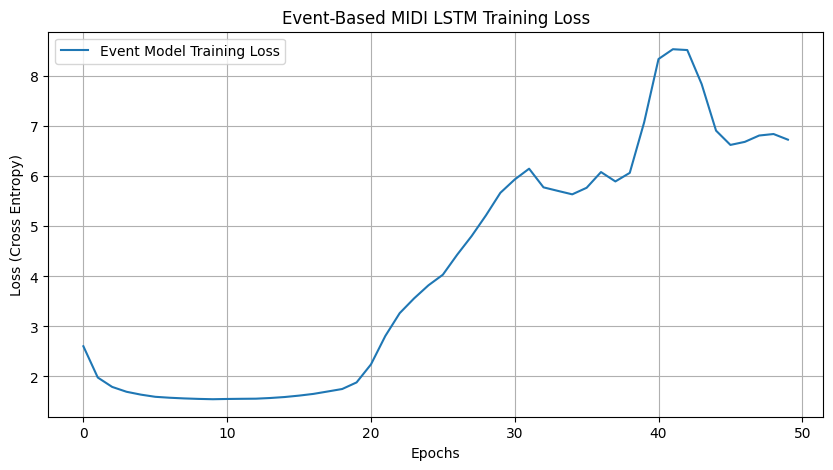

Event model state dictionary saved to: /kaggle/working/music_lstm_model_event.pth


In [10]:
import torch.optim as optim
import torch.nn as nn
import torch 
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt 
import time

num_epochs_midi_event = 50     
learning_rate_event = 0.002   
clip_value_event = 1.0        
try:
    if 'music_lstm_model_event' not in locals(): raise NameError("music_lstm_model_event")
    if 'train_loader_midi_event' not in locals(): raise NameError("train_loader_midi_event")
    if 'device' not in locals(): raise NameError("device")
    print("Event model, event DataLoader, and device seem to be defined.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run previous cells (Event Data Prep, Event Model Def).")
    raise 

criterion_event = nn.CrossEntropyLoss()
optimizer_event = optim.Adam(music_lstm_model_event.parameters(), lr=learning_rate_event)

print("\n--- Starting Event-Based Model Training ---")
start_time_train_event = time.time()
train_losses_midi_event = []

music_lstm_model_event.train() 

for epoch in range(num_epochs_midi_event):
    epoch_start_time = time.time()
    running_loss_event = 0.0

    progress_bar_train_event = tqdm(train_loader_midi_event, desc=f"Epoch {epoch+1}/{num_epochs_midi_event} (Event)", leave=False)

    for inputs, targets in progress_bar_train_event:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_event.zero_grad()

        outputs = music_lstm_model_event(inputs)
        loss = criterion_event(outputs, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(music_lstm_model_event.parameters(), clip_value_event)

        optimizer_event.step()

        running_loss_event += loss.item()

        progress_bar_train_event.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss_event = running_loss_event / len(train_loader_midi_event)
    train_losses_midi_event.append(epoch_loss_event) 
    epoch_end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs_midi_event}] (Event), Loss: {epoch_loss_event:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

end_time_train_event = time.time()
print(f"--- Finished Event Model Training in {end_time_train_event - start_time_train_event:.2f} seconds ---")

plt.figure(figsize=(10, 5))
plt.plot(train_losses_midi_event, label='Event Model Training Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Event-Based MIDI LSTM Training Loss')
plt.legend()
plt.grid(True)
plt.show()

model_save_path_event = "/kaggle/working/music_lstm_model_event.pth" 
torch.save(music_lstm_model_event.state_dict(), model_save_path_event)
print(f"Event model state dictionary saved to: {model_save_path_event}")

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm.notebook import tqdm 

events_to_generate = 500   
temperature = 0.8         
try:
    if 'n_vocab_event' not in locals(): raise NameError("n_vocab_event")
    if 'sequence_length_event' not in locals(): raise NameError("sequence_length_event")
    if 'event_to_int' not in locals(): raise NameError("event_to_int")
    if 'int_to_event' not in locals(): raise NameError("int_to_event")
    if 'network_input_event' not in locals(): raise NameError("network_input_event (from Event Data Prep)")
    if 'device' not in locals(): raise NameError("device")
    if 'MusicLSTM' not in locals(): raise NameError("MusicLSTM class definition")
    print("Required variables for event generation seem to be defined.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run previous relevant steps (Event Data Prep, Event Model Def).")
    raise

model_load_path_event = "/kaggle/working/music_lstm_model_event.pth"
model_loaded_for_gen_event = False
try:
    embedding_dim_event = 256
    hidden_size_event = 512
    num_layers_event = 2
    dropout_prob_event = 0.3

    generation_model_event = MusicLSTM(n_vocab_event, embedding_dim_event, hidden_size_event, num_layers_event, dropout_prob_event)
    generation_model_event.load_state_dict(torch.load(model_load_path_event))
    generation_model_event = generation_model_event.to(device)
    generation_model_event.eval() 
    print(f"Event model loaded successfully from {model_load_path_event}")
    model_loaded_for_gen_event = True
except FileNotFoundError:
    print(f"ERROR: Event model file not found at {model_load_path_event}.")
except Exception as e:
    print(f"ERROR: Failed to load the event model: {e}")

generated_sequence_int_event = [] 

if model_loaded_for_gen_event and 'network_input_event' in locals() and len(network_input_event) > 0:
    print(f"\nGenerating {events_to_generate} events...")

    start_index_event = np.random.randint(0, len(network_input_event) - 1)
    if isinstance(network_input_event, list):
        network_input_event_np = np.array(network_input_event)
    else:
        network_input_event_np = network_input_event 
    seed_pattern_event_int = network_input_event_np[start_index_event] 
    print(f"Using seed pattern index: {start_index_event}")

    current_sequence_tensor = torch.tensor([seed_pattern_event_int], dtype=torch.long).to(device)
    generated_sequence_int_event.extend(seed_pattern_event_int.tolist())

    with torch.no_grad():
        for i in tqdm(range(events_to_generate), desc="Generating Events"):
            prediction_logits = generation_model_event(current_sequence_tensor)
            prediction_logits = prediction_logits / temperature

            probabilities = F.softmax(prediction_logits, dim=-1).squeeze()
            if torch.isnan(probabilities).any() or torch.isinf(probabilities).any():
                print("\nWarning: Probabilities contain NaN/Inf, choosing randomly.")
                predicted_index = random.randint(0, n_vocab_event - 1)
            else:
                predicted_index = torch.multinomial(probabilities, num_samples=1).item()

            generated_sequence_int_event.append(predicted_index)

            next_sequence_np = np.append(current_sequence_tensor.cpu().numpy().flatten()[1:], predicted_index)
            current_sequence_tensor = torch.tensor([next_sequence_np], dtype=torch.long).to(device)

    print(f"\nGenerated event sequence length: {len(generated_sequence_int_event)} events (including seed).")

    generated_events_str = [int_to_event.get(idx, f"UNK_{idx}") for idx in generated_sequence_int_event[:100]]
    print("\nFirst 100 generated events (decoded):")
    print(generated_events_str)

else:
    print("\nCould not generate music because the event model wasn't loaded or seed data is missing.")
    generated_sequence_int_event = [] 

Required variables for event generation seem to be defined.
Event model loaded successfully from /kaggle/working/music_lstm_model_event.pth

Generating 500 events...
Using seed pattern index: 89631


/tmp/ipykernel_19/381026663.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generation_model_event.load_state_dict(torch.load(model_load_path_event))


Generating Events:   0%|          | 0/500 [00:00<?, ?it/s]


Generated event sequence length: 650 events (including seed).

First 100 generated events (decoded):
['NOTE_42', 'NOTE_80', 'NOTE_68', 'NOTE_71', 'NOTE_76', 'NOTE_64', 'NOTE_64', 'NOTE_68', 'TIME_4', 'NOTE_40', 'TIME_8', 'NOTE_61', 'NOTE_61', 'NOTE_66', 'TIME_11', 'NOTE_52', 'NOTE_42', 'NOTE_59', 'NOTE_59', 'NOTE_64', 'TIME_27', 'NOTE_56', 'NOTE_59', 'NOTE_52', 'NOTE_36', 'NOTE_42', 'TIME_27', 'NOTE_64', 'NOTE_61', 'NOTE_52', 'NOTE_38', 'NOTE_42', 'TIME_27', 'NOTE_59', 'NOTE_38', 'NOTE_42', 'TIME_4', 'NOTE_38', 'TIME_26', 'NOTE_55', 'NOTE_52', 'NOTE_59', 'NOTE_40', 'NOTE_36', 'NOTE_42', 'TIME_4', 'NOTE_40', 'TIME_26', 'NOTE_42', 'NOTE_49', 'NOTE_42', 'NOTE_68', 'NOTE_64', 'NOTE_42', 'NOTE_36', 'NOTE_42', 'NOTE_78', 'NOTE_66', 'NOTE_69', 'NOTE_73', 'NOTE_57', 'NOTE_57', 'NOTE_61', 'TIME_4', 'NOTE_42', 'TIME_26', 'NOTE_54', 'NOTE_42', 'TIME_27', 'NOTE_57', 'NOTE_36', 'NOTE_42', 'TIME_27', 'NOTE_61', 'NOTE_49', 'NOTE_42', 'NOTE_38', 'NOTE_42', 'NOTE_57', 'NOTE_57', 'NOTE_61', 'TIME_27', 

Required variables for MIDI conversion seem to be defined.

Converting 650 events to MIDI notes...


Creating MIDI Notes:   0%|          | 0/650 [00:00<?, ?it/s]


Generated Event-Based MIDI file saved successfully to: /kaggle/working/generated_midi/lstm_generated_melody_event.mid
Total notes written to MIDI: 465
You can download this file and listen to it.

Generating event-based piano roll visualization...


/tmp/ipykernel_19/4043907076.py:98: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll_event, sr=fs_event*10,


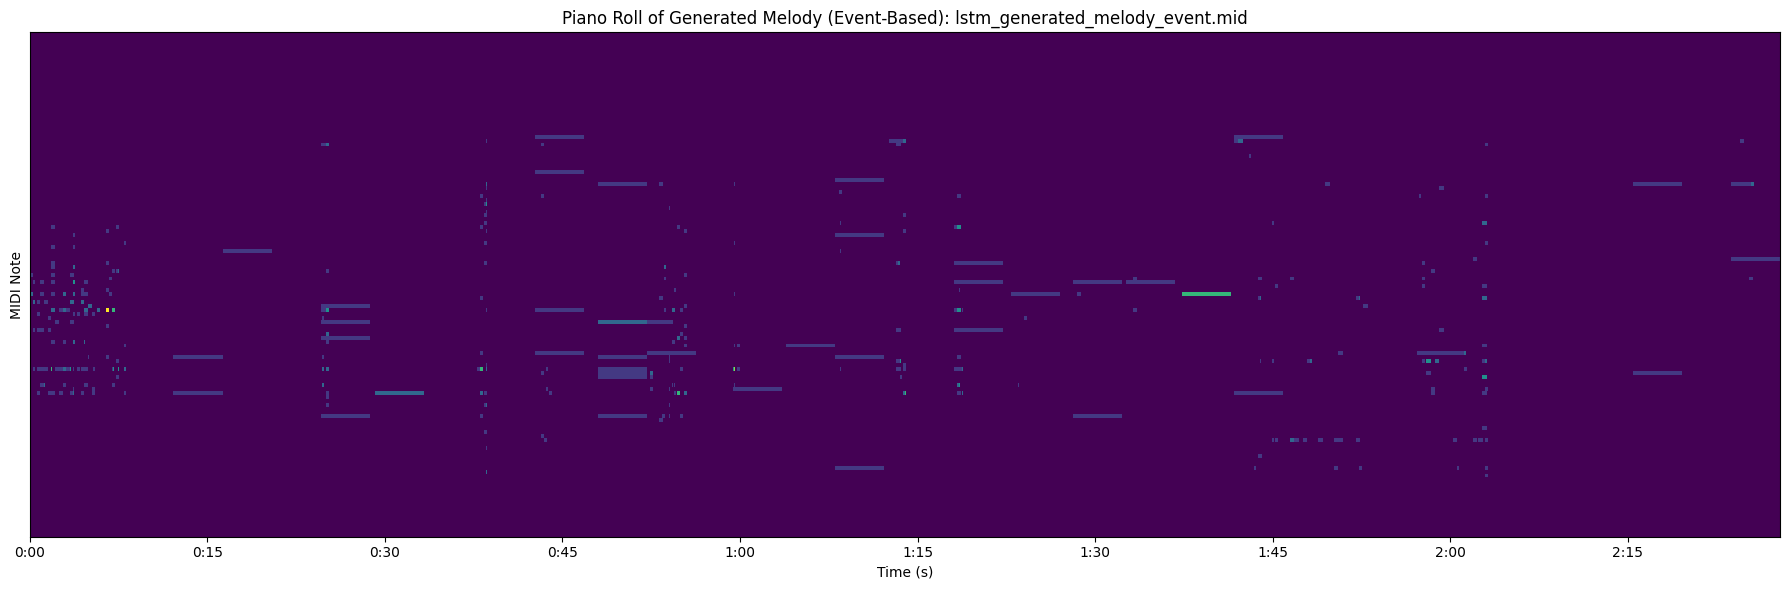

In [12]:
# --- Adım C.6 (Revize Edilmiş V2 - YENİ HÜCRE): Event-Based Çıktıyı MIDI'ye Dönüştürme ve Görselleştirme ---

import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np


try:
    if 'generated_sequence_int_event' not in locals() or not generated_sequence_int_event:
         raise NameError("generated_sequence_int_event")
    if 'int_to_event' not in locals(): raise NameError("int_to_event")
    if 'time_bin_edges' not in locals(): raise NameError("time_bin_edges")
    if 'midi_save_dir' not in locals(): raise NameError("midi_save_dir")
    # if 'viz_save_dir' not in locals(): raise NameError("viz_save_dir")
    print("Required variables for MIDI conversion seem to be defined.")
except NameError as e:
    print(f"ERROR: Required variable {e} is not defined. Please run previous relevant steps.")
    raise

midi_filename_event = "lstm_generated_melody_event.mid"
midi_filepath_event = os.path.join(midi_save_dir, midi_filename_event)

velocity = 100

midi_out_event = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano_instrument = pretty_midi.Instrument(program=piano_program, name='LSTM Event Generated Piano')

current_time = 0.0
last_time_shift_duration = 0.1 

print(f"\nConverting {len(generated_sequence_int_event)} events to MIDI notes...")

def get_duration_from_bin(bin_idx, bin_edges):
    if bin_idx < 0 or bin_idx >= len(bin_edges) - 1:
        return 0.1 
    return (bin_edges[bin_idx+1] + bin_edges[bin_idx]) / 2

event_count = len(generated_sequence_int_event)
notes_added = 0
for i, event_index in enumerate(tqdm(generated_sequence_int_event, desc="Creating MIDI Notes")):
    event_str = int_to_event.get(event_index, None)

    if event_str is None:
        continue 

    if event_str.startswith("TIME_"):
        try:
            bin_idx = int(event_str.split('_')[-1])
            time_shift_duration = get_duration_from_bin(bin_idx, time_bin_edges)
            current_time += time_shift_duration
            last_time_shift_duration = time_shift_duration 
        except (ValueError, IndexError):
             print(f"Warning: Could not parse time bin index from event: {event_str}")
             current_time += last_time_shift_duration 

    elif event_str.startswith("NOTE_"):
        try:
            pitch = int(event_str.split('_')[-1])
            duration = last_time_shift_duration

            start_time = current_time 
            end_time = start_time + duration

            if duration < 0.05: duration = 0.05 

            note = pretty_midi.Note(
                velocity=velocity, pitch=pitch, start=start_time, end=end_time
            )
            piano_instrument.notes.append(note)
            notes_added += 1
        except (ValueError, IndexError):
             print(f"Warning: Could not parse pitch from event: {event_str}")

midi_out_event.instruments.append(piano_instrument)

try:
    midi_out_event.write(midi_filepath_event)
    print(f"\nGenerated Event-Based MIDI file saved successfully to: {midi_filepath_event}")
    print(f"Total notes written to MIDI: {notes_added}")
    print("You can download this file and listen to it.")
except Exception as e:
    print(f"\nError saving event-based MIDI file: {e}")

print("\nGenerating event-based piano roll visualization...")
try:
    pm_event = pretty_midi.PrettyMIDI(midi_filepath_event)

    fs_event = 100 
    piano_roll_event = pm_event.get_piano_roll(fs=fs_event)

    plt.figure(figsize=(18, 6)) 
    times_event = np.arange(piano_roll_event.shape[1]) / float(fs_event)

    librosa.display.specshow(piano_roll_event, sr=fs_event*10,
                             hop_length=int(fs_event*0.1),
                             x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(1),
                             cmap='viridis') 
    plt.title(f'Piano Roll of Generated Melody (Event-Based): {midi_filename_event}')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Note')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Could not visualize: Event-based MIDI file not found.")
except Exception as e:
    print(f"Error during event-based visualization: {e}")